In [1]:
%matplotlib inline
import datascrape as ds
from datetime import date
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
sns.set_style('whitegrid')

/Users/charlesliu/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df = pd.read_csv('data/KBOS-2012.csv')

In [3]:
df.columns

Index(['EST', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles', ' Min VisibilityMiles',
       ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH',
       'PrecipitationIn', ' CloudCover', ' Events', ' WindDirDegrees'],
      dtype='object')

In [4]:
# All data
dd = ds.dictdf(ds.munis, date(1960, 1, 1), date(2015, 12, 31))

### Preprocessing the data
We quantize the measured precipitation in inches into the following buckets:

0 - 0.02 (No rain)

0.02 - 0.065

0.065 - 0.15

0.15 - 0.3

0.3 - 0.6

\> 0.6

In [5]:
num_measurements = len(dd["KBOS"])
rain_measurements = np.zeros(num_measurements*len(dd))
for ii, muni in enumerate(dd):
    rain_measurements[ii*num_measurements:(ii+1)*num_measurements] = dd[muni].PrecipitationIn.values

[0, 3, 0, 60987.0]

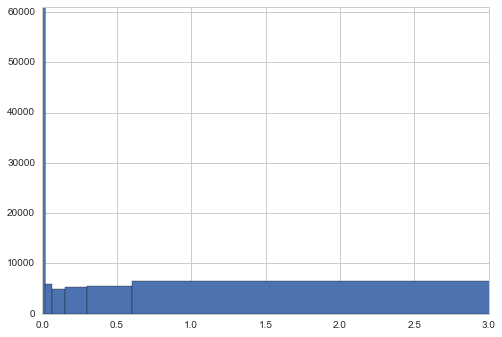

In [6]:
# hardcode bins to make each bin roughly equal in size
bins = [0.0, 0.02, 0.065, .15, .3, .6, 60]
n, bins, patches = plt.hist(rain_measurements, bins=bins)
plt.axis([0, 3, 0, max(n)])

In [7]:
# get dictionary from muni -> df to just muni -> rain measurements and muni -> discrete levels
rain_discrete = {}
rain_measure = {}
for muni in dd:
    rain_measure[muni] = dd[muni].PrecipitationIn.values
    rain_discrete[muni] = np.digitize(dd[muni].PrecipitationIn.values, bins)

#### Ordering of stations (nodes)
In order to compute a dependecy DAG between stations, we need for the k2 algorithm a (topological) ordering of the stations. To obtain this automatically (for a in-depth weather model dependencies should be picked carefully manually and changed over the time) we use a combination of a Minimum Spanning Tree (MST) and Breadth First Search (BFS) on it to obtain a valid ordering.

In [8]:
# run brew install geos
# then get tarball from http://matplotlib.org/basemap/users/installing.html
# run python3 setup.py install

# get cartopy from https://github.com/SciTools/Cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [9]:
# helper function to plot the region around the stations out
def plot_MA_map(water_color=sns.xkcd_rgb["baby blue"], \
    land_color=sns.xkcd_rgb["beige"], \
    marker_color=sns.xkcd_rgb["chocolate brown"], \
    arrow_color=sns.xkcd_rgb["dull red"]):

    map = Basemap(llcrnrlon=-74.5,llcrnrlat=40.75,urcrnrlon=-69.75,urcrnrlat=43, resolution = 'h')
    map.drawstates(color='white', linewidth=2)
    map.drawmapboundary(fill_color=water_color)
    map.fillcontinents(color=land_color,lake_color=water_color)
    map.drawrivers(color=water_color, zorder=-1)
    
    return map

We estimate the ordering via a minimum spanning tree based on euclidean distance (lon/lat due to the small relative scale still this is feasible). The estimation is done by using scipy's new graph features. To speedup the computation we do not relie on the complete graph but build instead a preliminary graph using k-nearest neighbor search (here with 6 neighbors).

In [10]:
# load lon/lat data and join with station names
dfgeo = pd.read_csv('data/geoinfo.tsv', sep='\t')
dfgeo.set_index('name', inplace=True)
dfmunis = pd.DataFrame(list(ds.munis.items()), columns=['code', 'name'])
dfmunis.set_index('name', inplace=True)

dfjoined = dfmunis.join(dfgeo)
dfjoined.reset_index(inplace=True)
dfjoined.head(20)

,name,code,lat,lon
0,Bridgeport,KBDR,41.17,73.13
1,Providence,KPVD,41.73,71.43
2,New York,KNYC,40.77,73.98
3,Purchase,KHPN,41.04,73.71
4,Lawrence,KLWM,42.72,71.12
5,New Bedford,KEWB,41.68,70.97
6,New Haven,KHVN,41.22,72.67
7,Bedford,KBED,42.47,71.28
8,Norwood,KOWD,42.18,71.18
9,Pittsfield,KPSF,42.26,73.18


In [11]:
# produce ordering using a minimum spanning tree based on distance as edge weights
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

X = dfjoined[['lon', 'lat']].values
# use 6 nearest neighbors to generate preliminary graph
G = kneighbors_graph(X, n_neighbors=6, mode='distance')
# compute the minimum spanning tree of this graph
T = minimum_spanning_tree(G, overwrite=True)
# retrieve coordinates
T = T.tocoo()

dist = T.data
p1 = T.row
p2 = T.col
A = X[p1].T
B = X[p2].T
lon_coords = np.vstack([A[0], B[0]])
lat_coords = np.vstack([A[1], B[1]])

The following code produces a nice image of the minimum spanning tree obtained via Kruskal's algorithm:

In [12]:
def plot_map_mst(map, lon_coords, lat_coords, marker_color=sns.xkcd_rgb["chocolate brown"], \
    arrow_color=sns.xkcd_rgb["dull red"]):
    
    def plot_mst(map, lon_coords, lat_coords):
        assert(lon_coords.shape == lat_coords.shape)
        coeff_cut = 0.06
        for i in range(lon_coords.shape[1]):
            lons = -np.array([lon_coords[0, i], lon_coords[1, i]])
            lats = np.array([lat_coords[0, i], lat_coords[1, i]])

            x, y = map(lons, lats)

            dx = x[1] - x[0]
            dy = y[1] - y[0]
            plt.arrow(x[0] + coeff_cut * 0.5 * dx, y[0] + coeff_cut * 0.5 * dy, \
                      (1.0 - coeff_cut)* dx, (1.0 - coeff_cut) * dy,\
                      shape='full', lw=1.35, length_includes_head=True, head_width=.0,\
                      fc=arrow_color, ec=arrow_color, zorder=25)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    for label, xpt, ypt in zip(labels, x, y):
        #manual positioning fix
        if label == 'Westfield':
            plt.text(xpt+2*offset, ypt-3*offset, label, zorder=30)
        else:  
            plt.text(xpt+offset, ypt+offset, label,zorder=30)
    plot_mst(map, lon_coords, lat_coords)

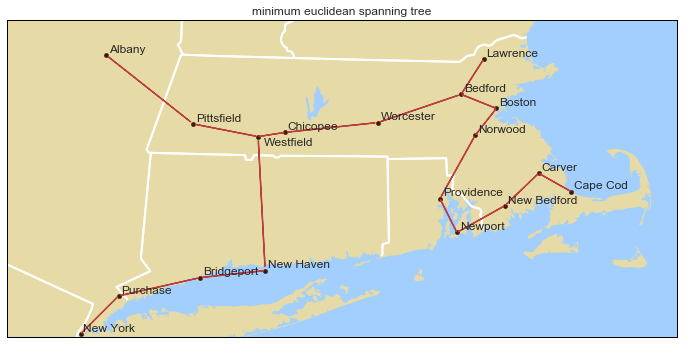

In [13]:
plt.figure(figsize=(12, 7))
euc_map = plot_MA_map()
plot_map_mst(euc_map, lon_coords, lat_coords)
plt.title('minimum euclidean spanning tree')

We now infer a topological ordering via BFS. It is up to the user to pick a meaningful start node (probably a node with many children).

In [14]:
from enum import Enum

adj_matrix = T.toarray()

class Color(Enum):
    GRAY = 1 # next to visit
    WHITE = 0 # non-visited
    BLACK = 2 # visited
# determine an ordering from a MST via some tree search (choose BFS here)
num_nodes = adj_matrix.shape[0]
colors = np.array([Color.WHITE] * num_nodes)
# some start node (here the first one --> let the user choose this one)
start_node = 0
order = []
colors[start_node] = Color.GRAY
order.append(start_node) # whenever something is GRAYED add to order...
queue = []
queue.append(start_node)
while len(queue) > 0:
    #dequeue
    u = queue[0]
    queue = queue[1:]
    
    for v in range(num_nodes):
        #adjacent ?
        if adj_matrix[u, v] > 0 or adj_matrix[v, u] > 0:
            if colors[v] == Color.WHITE: # not visited yet?
                colors[v] = Color.GRAY
                order.append(v)
                queue.append(v)
    colors[u] = Color.BLACK

In [15]:
# the obtained order
order

[0, 3, 6, 2, 11, 9, 13, 15, 16, 7, 4, 14, 8, 1, 10, 5, 17, 12]

In [16]:
# helper function to visualize the order onto a map
def plot_map_order(map, order, marker_color=sns.xkcd_rgb["chocolate brown"]):
    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    pos = 1
    for i in order:
        label, xpt, ypt = labels[i], x[i], y[i]
        #manual positioning fix
        if label == 'Westfield':
            label = ''
            plt.text(xpt+2*offset, ypt-3*offset, label + ' ({})'.format(pos), zorder=30, fontsize=16)
        else:  
            label = ''
            plt.text(xpt+offset, ypt+offset, label + ' ({})'.format(pos),zorder=30, fontsize=16)
        pos += 1

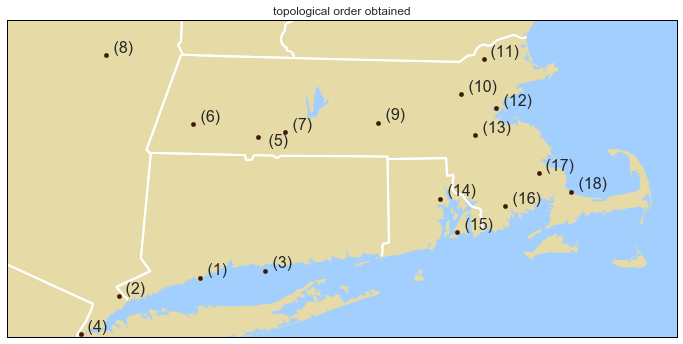

In [17]:
plt.figure(figsize=(12, 7))
top_map = plot_MA_map()
plot_map_order(top_map, order)
plt.title('topological order obtained')

In [18]:
# convert ordering to station codes
node_ordering = []
key_vals = list(ds.munis.keys())
for idx in order:
    node_ordering.append( key_vals[idx])

In [19]:
# current ordering
node_ordering

['KBDR',
 'KHPN',
 'KHVN',
 'KNYC',
 'KBAF',
 'KPSF',
 'KCEF',
 'KALB',
 'KORH',
 'KBED',
 'KLWM',
 'KBOS',
 'KOWD',
 'KPVD',
 'KUUU',
 'KEWB',
 'KPYM',
 'KFMH']

In [20]:
ord_relation ={}
for i in range(len(node_ordering) - 1):
    ord_relation[node_ordering[i+1]] = [node_ordering[i]]
ord_relation

{'KALB': ['KCEF'],
 'KBAF': ['KNYC'],
 'KBED': ['KORH'],
 'KBOS': ['KLWM'],
 'KCEF': ['KPSF'],
 'KEWB': ['KUUU'],
 'KFMH': ['KPYM'],
 'KHPN': ['KBDR'],
 'KHVN': ['KHPN'],
 'KLWM': ['KBED'],
 'KNYC': ['KHVN'],
 'KORH': ['KALB'],
 'KOWD': ['KBOS'],
 'KPSF': ['KBAF'],
 'KPVD': ['KOWD'],
 'KPYM': ['KEWB'],
 'KUUU': ['KPVD']}

### Bayesian Network With K2

In [31]:
# helper function to increment counter in dict
def inc(dic, key):
    if key in dic:
        dic[key] += 1
    else:
        dic[key] = 1
        
# helper function to get conditional probability
def conditional_prob(muni, muni_bucket, parents):
    parents_count = 1
    parents_muni_count = 1
    for i in range(num_measurements):
        parents_row = True
        for parent, bucket in parents.items():
            if rain_discrete[parent][i] != bucket:
                parents_row = False
                break
        if parents_row:
            parents_count += 1
            if rain_discrete[muni][i] == muni_bucket:
                parents_muni_count += 1
    return parents_muni_count/parents_count
        
# helper function for k2, calculate probability of some municipality and list of parents
def log_probability(muni, parents):
    p = 0
    discrete_counts = {}
    for i in range(num_measurements):
        key = []
        for parent in parents:
            key.append(rain_discrete[parent][i])
        key = tuple(key)
        key2 = rain_discrete[muni][i]
        if key in discrete_counts:
            inc(discrete_counts[key], key2)
        else:
            discrete_counts[key] = {key2: 1}
            
    for permutation in discrete_counts:
        total_instances = 0
        for k in range(1, len(bins)):
            if k in discrete_counts[permutation]:
                instances = discrete_counts[permutation][k]
                total_instances += instances
                p += np.sum(list(map(lambda x: np.log(x), range(1, instances))))
        p += np.sum(list(map(lambda x: np.log(x), range(1, len(bins) - 1))))
        p -= np.sum(list(map(lambda x: np.log(x), range(1, total_instances + len(bins) - 1))))
    return p

# helper function to calculate total log probability
def BayesNetLog(adjacency_dict):
    p = 0
    for muni, parents in adjacency_dict.items():
        p += log_probability(muni, parents)
    return p

# k2 algorithm
def k2(node_ordering, max_parents):
    adjacency_dict = {}
    # keep track of munis we've come across to avoid cycles
    visited_munis = set()
    for muni in node_ordering:
        parents = []
        p_old = log_probability(muni, parents)
        keepGoing = True
        while keepGoing and len(parents) < max_parents:
            # greedily choose the next neighbor to add calculating log_probability
            # from adding a neighbor that hasn't been visited yet
            p_best = -np.inf
            best_neighbor = None
            neighbors = visited_munis - set(parents)
            if len(neighbors) > 0:
                neighbors = list(map(lambda x: (x, log_probability(muni, parents + [x])), neighbors))
                best_neighbor, p_best = max(neighbors, key=lambda x: x[1])
            if p_best > p_old:
                p_old = p_best
                parents = parents + [best_neighbor]
            else:
                keepGoing = False
        adjacency_dict[muni] = parents
        visited_munis.add(muni)
    return adjacency_dict

In [22]:
k2_max3 = k2(node_ordering, 3)

In [23]:
k2_max3

{'KALB': ['KPSF', 'KCEF'],
 'KBAF': ['KNYC'],
 'KBDR': [],
 'KBED': ['KORH', 'KBAF'],
 'KBOS': ['KORH', 'KBED'],
 'KCEF': ['KBAF', 'KBDR'],
 'KEWB': ['KUUU', 'KOWD'],
 'KFMH': ['KEWB'],
 'KHPN': ['KBDR'],
 'KHVN': ['KBDR'],
 'KLWM': ['KBED', 'KORH'],
 'KNYC': ['KBDR', 'KHPN'],
 'KORH': ['KCEF', 'KBAF'],
 'KOWD': ['KBED', 'KBOS'],
 'KPSF': ['KBAF'],
 'KPVD': ['KBOS', 'KBDR'],
 'KPYM': ['KEWB', 'KUUU'],
 'KUUU': ['KPVD']}

### Simulated Annealing on K2 Result

In [24]:
node_idx = dict(zip(node_ordering, range(len(node_ordering))))
idx_node = dict(zip(range(len(node_ordering)), node_ordering))
switchable_nodes = node_ordering[1:]
# create algorithm to randomly reassign dependencies
def reassign_deps(adjacency_dict, num_parents):
    rand_muni = np.random.choice(switchable_nodes)
    rand_parents = list(map(lambda x: idx_node[x], np.random.choice(range(node_idx[rand_muni]), \
                            size=min(num_parents,node_idx[rand_muni]), replace=False)))
    adjacency_dict[rand_muni] = rand_parents
    return adjacency_dict

In [25]:
temperature = 10.0
#start with resulting adjacency from k2
adj_mat = k2_max3
best_found = BayesNetLog(adj_mat)
best_mat = dict(adj_mat)
err_trace = [best_found]
prev_E = best_found
m = 100
ftol = 0.01

for i in range(1000):
    # swaps for new corr matrix
    num_swaps = np.max([1,np.random.choice(np.floor(np.sqrt(temperature)).astype(int))])
    new_adj_mat = reassign_deps(adj_mat, num_swaps)
    new_E = BayesNetLog(new_adj_mat)
    deltaE  =  new_E - prev_E
    # update check
    if deltaE > 0 or np.random.rand() < np.exp( deltaE/temperature):
        if best_found < new_E:
            best_found = new_E
            best_mat = dict(adj_mat)
        adj_mat = new_adj_mat
        prev_E = new_E
        err_trace.append(new_E)
    
    if len(err_trace) % 50 == 0:
        temperature *= 0.9
        if temperature < 0.1:
            temperature = 1.0
    
    if len(err_trace) > m and np.std(err_trace[-m:])/np.mean(err_trace[-m:]) < ftol:
        break

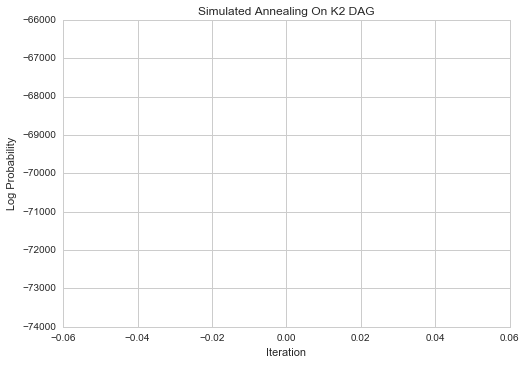

In [26]:
plt.xlabel("Iteration")
plt.ylabel("Log Probability")
plt.title("Simulated Annealing On K2 DAG")
plt.plot(err_trace)

In [27]:
best_mat

{'KALB': ['KPSF', 'KCEF'],
 'KBAF': ['KNYC'],
 'KBDR': [],
 'KBED': ['KORH', 'KBAF'],
 'KBOS': ['KORH', 'KBED'],
 'KCEF': ['KBAF', 'KBDR'],
 'KEWB': ['KUUU', 'KOWD'],
 'KFMH': ['KEWB'],
 'KHPN': ['KBDR'],
 'KHVN': ['KBDR'],
 'KLWM': ['KBED', 'KORH'],
 'KNYC': ['KBDR', 'KHPN'],
 'KORH': ['KCEF', 'KBAF'],
 'KOWD': ['KBED', 'KBOS'],
 'KPSF': ['KBAF'],
 'KPVD': ['KBOS', 'KBDR'],
 'KPYM': ['KEWB', 'KUUU'],
 'KUUU': ['KPVD']}

### Plotting a estimated dependecy relation via K2+SA algorithm
blablba....

In [ ]:
# relation is a dict with child : [parent1, parent2]
# arrows are from parents to child
def plot_map_graph(map, relation, \
    marker_color=sns.xkcd_rgb["chocolate brown"], \
    arrow_color=sns.xkcd_rgb["dull red"]):
    
    def plot_graph(map, relation):
        for child_code, parents in relation.items():
            #print(key, item)
            child = dfjoined[dfjoined['code'] == child_code]
            for parent_code in parents:
                parent = dfjoined[dfjoined['code'] == parent_code]
            lons = -np.array(list(parent['lon']) + list(child['lon']))
            lats = np.array(list(parent['lat']) + list(child['lat']))

            x, y = map(lons, lats)

            dx = x[1] - x[0]
            dy = y[1] - y[0]
            plt.arrow(x[0] + coeff_cut * 0.5 * dx, y[0] + coeff_cut * 0.5 * dy, \
                      (1.0 - coeff_cut)* dx, (1.0 - coeff_cut) * dy,\
                      shape='full', lw=1.35, length_includes_head=True, head_width=.04,\
                      fc=arrow_color, ec=arrow_color, zorder=25)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    for label, xpt, ypt in zip(labels, x, y):
        #manual positioning fix
        if label == 'Westfield':
            plt.text(xpt+2*offset, ypt-3*offset, label, zorder=30)
        else:  
            plt.text(xpt+offset, ypt+offset, label,zorder=30)

    coeff_cut = 0.06
    
    plot_graph(map, relation)


Let's first plot the node ordering we are actually using for the K2 algorithm

In [ ]:
plt.figure(figsize=(12, 7))
node_map = plot_MA_map()
plot_map_graph(node_map, ord_relation)

In [ ]:
# this plots out the dependency
plt.figure(figsize=(12, 7))
dep_map = plot_MA_map()
plot_map_graph(dep_map, best_mat)